# Tanque simple: Modelado del sistema

En el siguiente Notebook de Python, mostraremos modelar un sistema basado en principios físicos y linealizarlo por diferentes métodos de linealización.

principales comando de Python usados: de la biblioteca **pyhton-control:** ss , tf

<div class="alert alert-block alert-warning">
<b>Warning: </b> El siguiente notebook fue ejecutado con las versiones de la librería de python-control:  0.9.1:
</div> 

- [Modelo físico no lineal](#id_tk1)
    - [Parámetros del sistema](#id_tk1_1)
    - [Ecuaciones del sistema](#id_tk1_2)
    - [Punto de equilibrio y Condición Inicial](#id_tk1_3)
    - [Simulación del modelo no lineal usando python-control](#id_tk1_4)
- [Modelo linealizado por Taylor](#id_tk3)
- [Modelo en espacio de estados](#id_tk4)
- [Modelo en función de transferencia ](#id_tk5)
- [Citas y Referencias](#id_tk6)


<a id="id_tk1"></a>
## Modelo físico no lineal


Consideremos el siguiente sistemas, un tanque de área uniforme con una entrada y una salida, como muestra las siguiente figura:

<img src="fig1_tank_model.png">

<a id="id_tk1_1"></a>
### Parámetros del sistema:
- $A = 1 [m^2]$ área transversal del tanque
- $g = 9.81 [m^2/s]$ constante gravitacional
- $k = 0.1$ constante de salida del tanque
- $h $ altura o nivel del tanque en $m$
- $Q_i $ el caudal de entrada
- $Q_o $ el caudal de salida

Como hipótesis de modelado, consideraremos que el fluido en el tanque es agua, el área del tanque uniforme ($A$ es el mismo para todo valor de $h$), el área de salida del tanque es mucho menor que el área transversal del tanque (es lo habitual), el caudal de entrada $Q_i$ es proporcional a la apertura de válvula.


<a id="id_tk1_2"></a>
### Ecuaciones del sistema

Considerando las hipótesis del punto anterior simplificamos la contante de salida que llamaremos $k$, esta constante incluye, entre otras cosas, a $g$ y las áreas del tanque y de salida, $A$ y $A_2$.

<div class="alert alert-block alert-info">
<b>Ecuaciones del sistema no lineales:<b/>
<br/>
<br/>    
$$
\begin{split}
\frac{dh(t)}{dt} &= \frac{1}{A}(Q_i(t) - Q_o(t)) \newline
Q_o(t) &= k\sqrt{h(t)}
\end{split}
$$
</div>


<a id="id_tk1_3"></a>
### Punto de equilibrio y Condición Inicial
Para el punto de equilibrio cuando no hay variaciones del nivel, es decir el caudal de entrada y salida es el mismo:

$$\frac{\delta h(t)}{dt}=0 \Rightarrow  Q_i = Q_o$$ 

para el instante de tiempo $t=0$ definimos:

$$h(0)=h_0, \quad Q_i(0) = Q_{i0}\quad y \quad Q_o(0)= Q_{o0}$$

por lo cual:

$$Q_{o0} = k\sqrt{h_0}= Q_{i0} $$ 

finalmente la condición inicial queda definida por el valor de $h_0$, es decir el nivel inicial, luego podemos calcular el cacudal de salida y por consecuencia el de entrada que debe ser igual al caudal de salida. Esa es la condición inicial del sistema.

<div class="alert alert-block alert-success">
<b>Nota:</b> Es importante usar la condición inicial al simular por primera vez un sistema, con la finalidad de verificar que el modelo no tiene errores evidentes.
</div>

Los detalles del modelo dinámico los pueden ver en el siguiente video

[![tanque: descripción](fig2_video_part1.png)](https://www.youtube.com/watch?v=7G2o8KGon9A "Tanque: modelo y linealización")

<a id="id_tk1_4"></a>
### Simulación del modelo no lineal usando python-control

Hay muchas formas en Python para simular un modelo de un sistema no lineal, en este caso usamos un nuevo _Feature_ de la biblioteca de python-control que se encuentra a partir de la versión 0.9.1.

Como parte de las hipótesis del modelado y para evitar errores de cálculo, se limitó el nivel solo a valores positivos, es decir $h>=0$

In [1]:
import control as ctrl #biblioteca de control
import matplotlib.pyplot as plt #biblioteca para realizar graficos 2D
import numpy as np #biblioteca 

#es necesario versión 0.9.1 de la biblioteca de control
print('version de biblioteca de control: ', ctrl.__version__)

version de biblioteca de control:  0.9.3.post2


In [2]:
def derivs_fun(t, x, u, params):
    # Parametros, tienen valores por defecto
    k=params.get('k', 0.1)
    A=params.get('A', 1)
    h_min = params.get('h_min',0)  # h mínimo no puede ser negativo, por defecto h debe ser mayor a 0
    h_max = params.get('h_max',10) # h máximo debe ser mayor a h_max...por defecto a 10m 
    
    # variables de estado
    h = x[0]
    
    # Cálculo de la acción de control
    Qi = u if u > 0 else 0 # solo caudales positivos
    
    #calculo de la derivada de h... dh/dt
    h_sat = max(h_min, min(h, h_max))
    dh = (Qi - k*np.sqrt(h_sat))/A
    return [dh]

io_tank = ctrl.NonlinearIOSystem(
    derivs_fun, None, inputs=('u'), outputs=('h'),
    states=('h'), name='tank')


Con el **modelo no lineal** definido **io_tank**, podemos explorar la dinámica del sistema por simulación. 
Partiendo de un nivel inicial $h_0=3m$, por ejemplo, y con el caudal de entrada, $Q_i$, como el caudal de equilibrio $Q_i=Q_{o0} = k*\sqrt{h_0}$, luego deberíamos ver que el nivel del tanque se mantiene constante...veamos el resultado en la simulación

Caudal de equilibrio Qi0=  0.17320508075688773


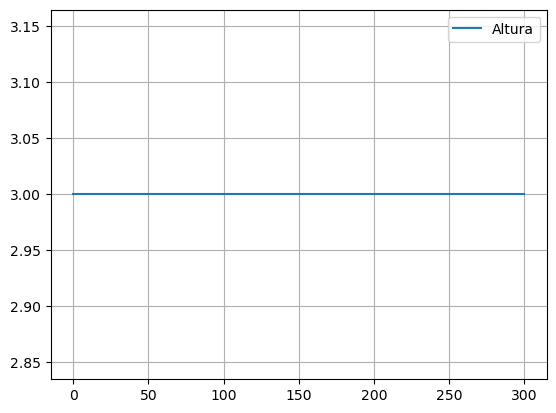

In [3]:
T = np.linspace(0, 300, 800)   # tiempo de simulacion
#parámetros del tanque
k=0.1
A_tank = 1 #defino el parámetro área del tanque, A como A_tanque, porque A es la matriz de estados

#condición inicial
h0 = 3                 # Altura inicial h0
Qi0 = k*np.sqrt(h0) #cálculo del caudal de equilibrio
print('Caudal de equilibrio Qi0= ',Qi0)

# Simulate the system
t, y = ctrl.input_output_response(io_tank, T, Qi0, h0)

# Plot the response
plt.figure(1)
plt.plot(t, y)
plt.legend(['Altura'])
plt.grid()
plt.show(block=False)


Ahora, a partir de la condición de equilibrio para el nivel definida en $h_0=3m$, analizamos la dinámica del sistema viendo la respuesta ante variaciones en el caudal de entrada, para lo que aumentamos y disminuimos el caudal de entrada un 10%, para ver que efecto tiene esto sobre el nivel.

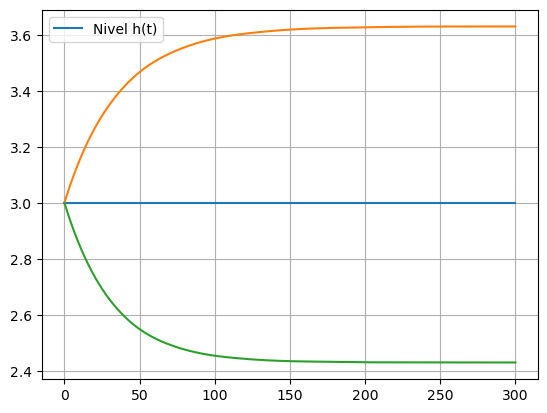

In [4]:
# Simulación no lineal con variaciones en el cuadal
t_nolin, y_nolin = ctrl.input_output_response(io_tank, T, Qi0, h0)
#aumentamos un 10% el caudal de entrada
t_nolin1, y_nolin1 = ctrl.input_output_response(io_tank, T, Qi0*1.1, h0) 
#disminuimos un 10% el caudal de entrada
t_nolin2, y_nolin2 = ctrl.input_output_response(io_tank, T, Qi0*.9, h0)

# Plot the response
plt.figure(1)
plt.plot(t_nolin, y_nolin)
plt.plot(t_nolin1, y_nolin1)
plt.plot(t_nolin2, y_nolin2)

plt.legend(['Nivel h(t)'])
plt.grid()
plt.show(block=False)

In [5]:
dh_1=round(100*(y_nolin1[-1]-y_nolin1[0])/y_nolin1[0]) #hint: y1 es un array el indice 0 es el primer elemento y -1 es el último
dh_2=round(100*(y_nolin2[-1]-y_nolin2[0])/y_nolin2[0])

print("Al aumentar el caudal de entrada dQi= 10%, la variación del nivel es, dh = ", dh_1,"%")
print("Al disminuir el caudal de entrada dQi= 10%, la variación del nivel es, ",dh_2,"%")

Al aumentar el caudal de entrada dQi= 10%, la variación del nivel es, dh =  21 %
Al disminuir el caudal de entrada dQi= 10%, la variación del nivel es,  -19 %


<div class="alert alert-block alert-success">
<b>Nota:</b> Observar que la variacíon porcentual del caudal de entrada de un 10%, no da una variación porcentual en el nivel de igual porcentaje, al aumentar, que al disminuir el caudal... Pensar, ¿Cuál sería la explicación?. Obviamente no tiene nada que ver con el sentido de la variación. 
</div>

<a id="id_tk3"></a>
## Modelo linealizado

Al linializar es necesario considerar el punto de equilibrio y las condiciones iniciale considerado en el punto anterior y luego para la parte lineal es solo un cambio de variable de la forma:

$$
\begin{split}
 h(t)   &= h_0+\delta h(t) \newline
 Q_i(t) &= Q_{i0}+\delta Q_i(t)\newline
 Q_o(t) &= Q_{o0}+\delta Q_o(t)
\end{split}
$$

entonces:

$$
\frac{dh(t)}{dt}=\frac{d(h_0+\delta h(t))}{dt}=\frac{\delta h(t)}{dt}=\frac{1}{A}( \underbrace{Q_{i0} - Q_{o0}}_{=0 \, pto. eq.}+ \delta Q_i(t)-\delta Q_o(t))$$

Linealizando la segunda ecuación, aplicamos Taylor y nos quedamos con el término lineal:
$$
Q_o(t)= Q_{o0}+\delta Q_o(t) \approx k\sqrt{h_o}+\frac{d\{k\sqrt{h(t)}\}}{dh}\bigg\rvert_{h=h_0}\underbrace{\Bigl( h(t)-h(0)\Bigl)}_{=\delta h(t)}
$$
haciendo los cálculos y cambios de variables llegamos a:
$$
\delta Q_o(t) = \underbrace{k\sqrt{h_o}-Q_{o0}}_{=0 \, pto. eq.}+\frac{k}{2\sqrt{h_o}}\delta h(t)
$$

      
<div class="alert alert-block alert-info">
Finalmente, las <b>ecuaciones del sistema linealizado</b> queda de la forma:
<br/>
<br/>
   $$
   \begin{split}
   \dot{\delta h}(t) & = \frac{1}{A}\Bigl(\delta Q_i(t)-\delta Q_o(t)\Bigl)\newline
       \delta Q_o(t) & =\frac{k}{2\sqrt{h_o}}\delta h(t)
   \end{split}
   $$
</div>

<a id="id_tk4"></a>
## Modelo en Espacio de Estados

Los sistemas de primer orden tienen solo un modo de acumlación de energía, en este caso energía potencial del nivel de líquido del tanque, y por lo tanto se necesita solo una variable de estado, el nivel, o mejor dicho las variaciones del nivel al rededor de $h_0$, definido como $\delta h(t)$. Donde:
$$
\mathbf{x}=\delta h(t) \rightarrow \dot{\mathbf{x}}(t)= \dot{\delta h}(t)\newline
\mathbf{u}=\delta Q_i(t)
$$
<div class="alert alert-block alert-info">
Por lo que, la representación en <b>variables de estado</b> es:
<br/>
<br/>
$$
\begin{split}
\dot{\mathbf{x}}&=\left[-\frac{k}{2\sqrt{h_o}}\right][\mathbf{x}]+\left[\frac{1}{A}\right][\mathbf{u}]\newline
y&=[1][\mathbf{x}]
\end{split}
$$
</div>

No hay que perder de vista que el estado del sistema son las variaciones del nivel $\delta h(t)$, al rededor del $h_0$, de la misma forma que la entrada deben ser las variaciones del caudal $\delta Q_i(t)$, al rededor del punto de equilibrio $Q_i0$

In [6]:
#k = 0.1
#A_tank = 1 #defino el parámetro área del tanque, A como A_tanque, porque A es la matriz de estados

#h0 = 3

A = -k/(2*np.sqrt(h0));
B = 1/A_tank;
C = 1;
D = 0;

tank_ss = ctrl.ss(A,B,C,D)
tank_ss

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

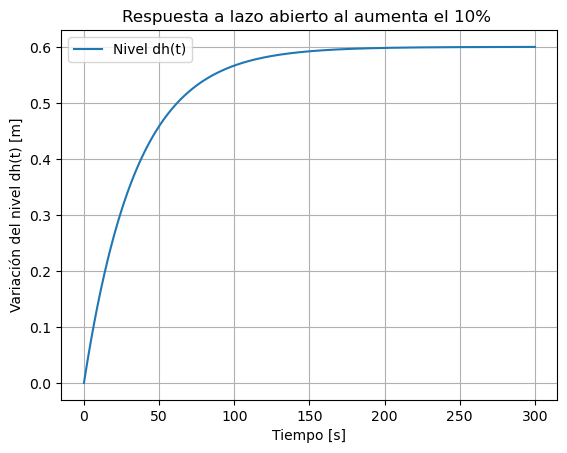

In [7]:
u = np.ones(T.size)*Qi0*.1 # es dQi=.1 un 10% de aumento 
x0 = [0] #recordar que el estado es dh =0

t_lin1,y_lin1,x_lin1 = ctrl.forced_response(tank_ss,U=u,T=T,X0=x0,return_x=True);
plt.plot(t_lin1,y_lin1)

plt.title('Respuesta a lazo abierto al aumenta el 10% ')
plt.xlabel('Tiempo [s]')
plt.ylabel('Variación del nivel dh(t) [m]');

plt.legend(['Nivel dh(t)'])
plt.grid()
plt.show(block=False)

En el siguiente gráfico, comparamos la respuesta ante la misma entrada del modelo lineal y no lineal.

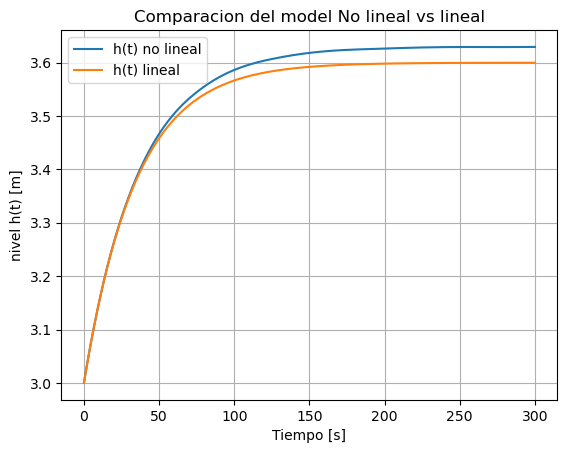

In [8]:
plt.plot(t_nolin1, y_nolin1,t_lin1,h0+y_lin1)

plt.title('Comparacion del model No lineal vs lineal')
plt.xlabel('Tiempo [s]')
plt.ylabel('nivel h(t) [m]');

plt.legend(['h(t) no lineal','h(t) lineal'])
plt.grid()
plt.show(block=False)

Observar la diferencia en las respuestas del sistema, esto es la evidencia del error de la linealización, dependiendo de la no linealidad y de la magnitud de la perturbación sera cuanto se separa el modelo linealizado del modelo no lineal. Corolario, las perturbaciones a un sistema linealizado deben ser pequeñas (¿Cuán pequeña? depende del sistema) para que el error sea pequeño.

In [9]:
h0=3
dh= y_lin1[-1]

print('error estimado :',abs(k/(2*np.sqrt(h0)))*abs(dh))
print('error real : ',  y_nolin1[-1]-(h0+y_lin1)[-1])
print('error relativo:',round((y_nolin1[-1]-(h0+y_lin1)[-1])/y_nolin1[-1]*100,2),' %')
print('número de condición:',round(h0*k/(2*np.sqrt(h0))/(k*np.sqrt(h0)),2))

error estimado : 0.01731750573420603
error real :  0.029558083855963257
error relativo: 0.81  %
número de condición: 0.5


<a id="id_tk5"></a>
## Modelo en Función de Transferencia
Tomando la transformada de Laplace de las ecuaciones linealizadas, obtenemos la función de transferencia de primer orden del tanque.

<div class="alert alert-block alert-info">
La <b>función de transferencia</b> queda de la forma:
<br/>
<br/>
   $$
   P(s)=\frac{\Delta H(s)}{\Delta Q_i(s)} = \frac{\frac{1}{A}}{(s +\frac{k}{2A\sqrt{h_o}})}  
   $$
</div>

In [10]:
P_tank = ctrl.tf(1/A_tank,[1,k/(2*A_tank*np.sqrt(h0))])
P_tank

TransferFunction(array([1.]), array([1.        , 0.02886751]))

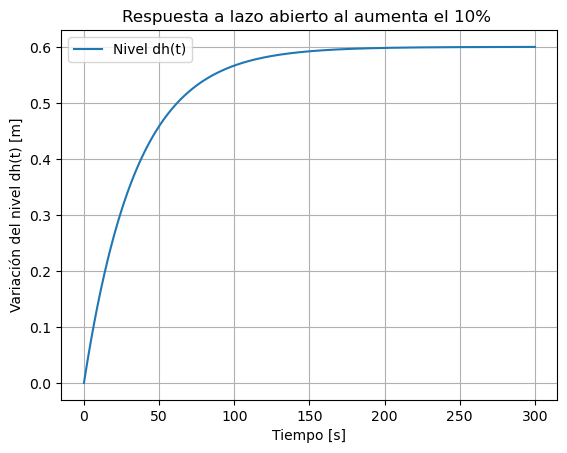

In [11]:
u = np.ones(T.size)*Qi0*.1 # es dQi=.1 un 10% de aumento 

t_lin2,y_lin2 = ctrl.forced_response(P_tank,U=u,T=T,X0=0);
plt.plot(t_lin2,y_lin2)

plt.title('Respuesta a lazo abierto al aumenta el 10% ')
plt.xlabel('Tiempo [s]')
plt.ylabel('Variación del nivel dh(t) [m]');

plt.legend(['Nivel dh(t)'])
plt.grid()
plt.show(block=False)

El resultado es claramente identico al obtenido por el sistema en variables de estado, las dos representaciones son equivalentes y es fácil de pasar de un sistema a otro usando las funciones ss2tf o tf2ss o simplemente "casteando" una función de transferencia con la función ss o un sistema en variables de estados con la función tf.

Los detalles del cálculo de la función de transferencia los pueden ver en el siguiente video

[![tanque: descripción](fig3_video_part2.png)](https://www.youtube.com/watch?v=vTh6FbaZ61s "Tanque: función de transferencia")

In [12]:
ctrl.ss(P_tank)

<LinearIOSystem:sys[7]:['u[0]']->['y[0]']>

---
<a id="id_tk7"></a>

## Citas y Referencias:

<div class="alert alert-block alert-info">
<b></b> Por ahora dejo las citas y referencia con este formato, si encuentro algo mejor lo cambio.
</div>


___
<a id="cite1"></a>
**REF#1: Control Tutorials for Matlab & Simulink**.

title = Introduction: State-Space Methods for Controller Design.   
url = https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlStateSpace    
note = Accessed: 2022-04-18   

___
<a id="cite2"></a>
**REF#2: Apuntes de Control Clásico y Variables de Estado**   

autor = Molina, Gonzalo  
url = https://gonmolina.github.io/CCyVE_book/sources/notebooks_sources/modulo1/linealizacion/linealizacion.html   
note = Accessed: 2022-04-18    

___ 
<a id="cite3"></a>    
**REF#3: Multivariable Feedback Control: Analysis and Design**

author = Skogestad, Sigurd and Postlethwaite, Ian   
year = 2005   
isbn = 0470011688   
publisher = John Wiley &amp; Sons, Inc.   
address = Hoboken, NJ, USA   

___

    
<!--bibtex
@misc{ctms,
  title = {{Control Tutorials for Matlab & Simulink} Introduction: State-Space Methods for Controller Design},
  howpublished = {\url{https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlStateSpace}},
  note = {Accessed: 2022-04-18}
  

@misc{CCyVE,
  title = {{Apuntes de Control Clásico y Variables de Estado} Linealización},
  author = {Molina, Gonzalo},
  howpublished = \url{https://gonmolina.github.io/CCyVE_book/sources/notebooks_sources/modulo1/linealizacion/linealizacion.html}},
  note = {Accessed: 2022-04-18}
  

 @book{10.5555/1121635,
    author = {Skogestad, Sigurd and Postlethwaite, Ian},
    title = {Multivariable Feedback Control: Analysis and Design},
    year = {2005},
    isbn = {0470011688},
    publisher = {John Wiley &amp; Sons, Inc.},
    address = {Hoboken, NJ, USA}
    }
 -->

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Licencia Creative Commons Atribución 4.0 Internacional</a>.